In [2]:
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
from IPython.display import display
import ee
import os

ee.Initialize()

Map = geemap.Map(center=[31.539096,-81.422318], zoom=10)

In [13]:
#Shapefiles used for extracting pixel values - all within the GCE domain

gce_clip = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simple.shp' ##Simplified GCE domain - reduced number of vertices
vcr_clip = 'F:/Wetlands shapefiles/VA_shapefile_wetlands/VA_simple.shp' ##Simplified VCR domain - reduced number of vertices
pie_clip = 'F:/Wetlands shapefiles/MA_shapefile_wetlands/MA_simple.shp' ##Simplified PIE domain - reduced number of vertices
wet_ga = geemap.shp_to_ee(gce_clip)
wet_va = geemap.shp_to_ee(vcr_clip)
wet_ma = geemap.shp_to_ee(pie_clip)
joinedFeatures = wet_ga.union()

gce_clipdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_simpledissolve.shp'
dissolve_ga = geemap.shp_to_ee(gce_clipdiss)

gce_smalldiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve.shp'
gce_smalldiss2 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve2.shp'
gce_smalldiss3 = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_smalldissolve3.shp'

smalldissolve_ga = geemap.shp_to_ee(gce_smalldiss)
small2dissolve_ga = geemap.shp_to_ee(gce_smalldiss2)
small3dissolve_ga = geemap.shp_to_ee(gce_smalldiss3)


#Note 1/18/23: Flux tower footprint (fluxproper) OR expanded flux area (fluxdiss)

gce_fluxdiss = 'F:/Wetlands shapefiles/GA_shapefile_wetlands/GA_fluxdissolve.shp'
gce_fluxproper = 'F:/Wetlands shapefiles/GCE flux tower/sapelo_yearly_climatology-2019.shp'

flux_ga = geemap.shp_to_ee(gce_fluxproper) #FOOTPRINT

In [14]:
#Adding wetlands 

Map.addLayer(flux_ga, {}, 'Flux tower')

Map

Map(bottom=855835.0, center=[31.431153192347107, -81.30586624145509], controls=(WidgetControl(options=['positi…

In [15]:
#Pixel counts of each region:
image = ee.Image('LANDSAT/LT05/C02/T1_L2/LT05_016038_19990711')
x = image.reduceRegion(geometry=flux_ga, reducer=ee.Reducer.count(), scale=30)
x.getInfo()

{'QA_PIXEL': 71,
 'QA_RADSAT': 71,
 'SR_ATMOS_OPACITY': 71,
 'SR_B1': 71,
 'SR_B2': 71,
 'SR_B3': 71,
 'SR_B4': 71,
 'SR_B5': 71,
 'SR_B7': 71,
 'SR_CLOUD_QA': 71,
 'ST_ATRAN': 71,
 'ST_B6': 71,
 'ST_CDIST': 71,
 'ST_DRAD': 71,
 'ST_EMIS': 71,
 'ST_EMSD': 71,
 'ST_QA': 71,
 'ST_TRAD': 71,
 'ST_URAD': 71}

In [16]:
##FLATS
def addFLATSL7(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(RED-SWIR)/(RED+SWIR) - 41.2*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL5(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.972*(RED-SWIR)/(RED+SWIR)-0.008) - 41.2*(0.991*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1)-0.0014)))', {
            'SWIR': image.select('SR_B5'),
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'BLUE': image.select('SR_B1')
        })
    
    return image.addBands(flats.rename('flats'))


def addFLATSL8(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(0.841*(RED-SWIR)/(RED+SWIR) - 0.019) - 41.2*(0.771*(NIR-RED)/(NIR+6*RED-7.5*BLUE+1) + 0.011)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

def addFLATSL9(image):
    flats = ee.Image(0).expression(
        '1/(1+2.718281828459045**-(1.51 + 12.5*(1.225*(RED-SWIR)/(RED+SWIR) + 0.096) - 41.2*(1.038* (NIR-RED)/(NIR+6*RED-7.5*BLUE+1) - 0.004)))', {
            'SWIR': image.select('SR_B6'),
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'BLUE': image.select('SR_B2')
        })
    
    return image.addBands(flats.rename('flats'))

#Note on landsat 9: calibrated to L7 - originally calibrated to L8

#Flats equation when evi is subbed in: flats = 1.51+(-41.2*evi) + 12.5*ndwi

##MASKING FLATS
def maskFLATS(image):
    mask1 = image.select('flats').lte(0.1) #less than or equal to 0.1 - change?
    return image.updateMask(mask1)

In [17]:
##Function to cloud mask from the pixel_qa band of Landsat 5/8 SR data.
def maskL5sr(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    saturationMask = image.select('QA_RADSAT').eq(0)
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True) \
    .addBands(thermalBands, None, True) \
    .updateMask(qaMask) \
    .updateMask(saturationMask)

In [18]:
#ndvi - before and after applying FLATs
##ADDING NDVI (for min/max variables)
def addL5ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B4'),
            'RED': image.select('SR_B3'),
            'GREEN': image.select('SR_B2')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

def addL8ndvi(image):
    ndvi = image.expression(
        '(NIR-RED)/(RED+NIR)', {
            'NIR': image.select('SR_B5'),
            'RED': image.select('SR_B4'),
            'GREEN': image.select('SR_B3')
        })
    
    return image.addBands(ndvi.rename('ndvi'))

In [19]:
#Mapping a continuous time series using calibrated data

l8_col = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga) \
    .map(maskL5sr).map(addFLATSL8).map(addL8ndvi)

l7_col = ee.ImageCollection('LANDSAT/LE07/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATSL7).map(addL5ndvi)

l5_col = ee.ImageCollection('LANDSAT/LT05/C02/T1_L2') \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

l9_col = ee.ImageCollection("LANDSAT/LC09/C02/T1_L2") \
    .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
    .filterBounds(dissolve_ga)\
    .map(maskL5sr).map(addFLATSL9).map(addL8ndvi)

In [20]:
L5_1 = l5_col.first()
L7_1 = l7_col.first()
L8_1 = l8_col.first()
L9_1 = l9_col.first()

Map.addLayer(L5_1, {'bands': ['flats'], 'min': 0, 'max': 1}, 'Flats L5')
Map.addLayer(L7_1, {'bands': ['flats'], 'min': 0, 'max': 1}, 'Flats L7')
Map.addLayer(L8_1, {'bands': ['flats'], 'min': 0, 'max': 1}, 'Flats L8')
Map.addLayer(L9_1, {'bands': ['flats'], 'min': 0, 'max': 1}, 'Flats L9')
Map

Map(bottom=3422203.0, center=[31.439831319100136, -81.28977298736574], controls=(WidgetControl(options=['posit…

In [21]:
#Hist

# import geemap.chart as chart

# source = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
#     .filter(ee.Filter.calendarRange(1998, 2023,'year')) \
#     .map(maskL5sr).map(addFLATSL8).map(addL8ndvi) \
#     .toBands()

# propx = 'SR_B1'

# region = dissolve_ga
# my_sample = source.sample(region, 5000)

# options = {
#     "title": 'cc',
#     "xlabel": 'B1',
#     "ylabel": 'Pixel count',
#     "colors": ['#1d6b99'],
# }

# chart.feature_histogram(my_sample, propx, **options)


In [22]:
#Pre-masking ndvi - L5
import pandas as pd
import numpy as np
from datetime import datetime as dt
import ee

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(addFLATSL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL5_unflats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [23]:
#Pixel count - Landsat 5, no flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(addFLATSL5(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL5_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [24]:
# outputL5_unflats['ndvi'].unique()
# outputL5_unflats['date'] = outputL5_unflats.index
# outputL5_unflats['Sensor'] = 'Landsat 5'
# outputL5_unflats

outputL5_unmasked = outputL5_unflats.copy()
outputL5_unmasked['ndvi'].unique()
outputL5_unmasked['date'] = outputL5_unmasked.index
outputL5_unmasked['Sensor'] = 'Landsat 5'

#Pixel count dataset
outputL5_count['date'] = outputL5_count.index
outputL5_count = outputL5_count.rename(columns={"ndvi": "count"})

outputL5_unflats = pd.merge(outputL5_unmasked, outputL5_count, on = 'date')
outputL5_unflats

,ndvi,date,Sensor,count
0,0.107253,1998-01-29 10:30:24.917,Landsat 5,71
1,0.317333,1998-02-14 10:30:44.901,Landsat 5,71
2,0.361933,1998-03-02 10:31:00.495,Landsat 5,71
3,NaN,1998-04-03 11:31:27.406,Landsat 5,0
4,NaN,1998-04-19 11:31:39.326,Landsat 5,0
...,...,...,...,...
499,NaN,2011-09-05 11:49:26.148,Landsat 5,0
500,0.372240,2011-09-21 11:49:11.923,Landsat 5,71
501,0.318831,2011-10-07 11:48:52.357,Landsat 5,71
502,0.327139,2011-10-23 11:48:45.289,Landsat 5,71


In [25]:
#Masking ndvi - L5

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(maskFLATS(addFLATSL5(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL5_flats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [26]:
#Pixel count - Landsat 5, flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(maskFLATS(addFLATSL5(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1998
    end_date = 2014
    product = 'LANDSAT/LT05/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL5_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [27]:
# outputL5_flats['ndvi'].unique()
# outputL5_flats['date'] = outputL5_flats.index
# outputL5_flats['Sensor'] = 'Landsat 5'
# outputL5_flats

#Flats
outputL5_masked = outputL5_flats.copy()

outputL5_masked['ndvi'].unique()
outputL5_masked['date'] = outputL5_masked.index
outputL5_masked['Sensor'] = 'Landsat 5'

#Pixel count dataset
outputL5_count['date'] = outputL5_count.index
outputL5_count = outputL5_count.rename(columns={"ndvi": "count"})

outputL5_flats = pd.merge(outputL5_masked, outputL5_count, on = 'date')

outputL5_flats

,ndvi,date,Sensor,count
0,0.271502,1998-01-29 10:30:24.917,Landsat 5,14
1,0.361920,1998-02-14 10:30:44.901,Landsat 5,55
2,0.393963,1998-03-02 10:31:00.495,Landsat 5,63
3,NaN,1998-04-03 11:31:27.406,Landsat 5,0
4,NaN,1998-04-19 11:31:39.326,Landsat 5,0
...,...,...,...,...
499,NaN,2011-09-05 11:49:26.148,Landsat 5,0
500,0.412654,2011-09-21 11:49:11.923,Landsat 5,43
501,0.364249,2011-10-07 11:48:52.357,Landsat 5,34
502,0.365800,2011-10-23 11:48:45.289,Landsat 5,42


In [28]:
#Pre-masking ndvi - L7

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL5).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(addFLATSL7(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1999
    end_date = 2018
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL7_unflats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [29]:
#Pixel count - Landsat 7, no flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL7).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(addFLATSL7(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1999
    end_date = 2022
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL7_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [30]:
# outputL7_unflats['ndvi'].unique()
# outputL7_unflats['date'] = outputL7_unflats.index
# outputL7_unflats['Sensor'] = 'Landsat 7'
# outputL7_unflats

outputL7_unmasked = outputL7_unflats.copy()
outputL7_unmasked['ndvi'].unique()
outputL7_unmasked['date'] = outputL7_unmasked.index
outputL7_unmasked['Sensor'] = 'Landsat 7'

#Pixel count dataset
outputL7_count['date'] = outputL7_count.index
outputL7_count = outputL7_count.rename(columns={"ndvi": "count"})

outputL7_unflats = pd.merge(outputL7_unmasked, outputL7_count, on = 'date')
outputL7_unflats

,ndvi,date,Sensor,count
0,0.408159,1999-07-03 11:47:21.373,Landsat 7,28
1,NaN,1999-07-19 11:47:24.693,Landsat 7,0
2,NaN,1999-08-04 11:47:31.813,Landsat 7,0
3,0.376056,1999-08-20 11:47:28.779,Landsat 7,69
4,0.342877,1999-09-05 11:47:32.931,Landsat 7,71
...,...,...,...,...
755,0.399080,2018-10-18 11:57:54.951,Landsat 7,58
756,0.411802,2018-11-03 11:57:34.666,Landsat 7,69
757,NaN,2018-11-19 10:57:12.160,Landsat 7,0
758,0.395102,2018-12-05 10:56:47.420,Landsat 7,35


In [31]:
#Masking ndvi - L7

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL7).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(maskFLATS(addFLATSL7(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1999
    end_date = 2018
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL7_flats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [32]:
#Pixel count - Landsat 7, flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL7).map(addL5ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL5ndvi(maskFLATS(addFLATSL7(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 1999
    end_date = 2022
    product = 'LANDSAT/LE07/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL7_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [33]:
# outputL7_flats['ndvi'].unique()
# outputL7_flats['date'] = outputL7_flats.index
# outputL7_flats['Sensor'] = 'Landsat 7'
# outputL7_flats

#Flats
outputL7_masked = outputL7_flats.copy()

outputL7_masked['ndvi'].unique()
outputL7_masked['date'] = outputL7_masked.index
outputL7_masked['Sensor'] = 'Landsat 7'

#Pixel count dataset
outputL7_count['date'] = outputL7_count.index
outputL7_count = outputL7_count.rename(columns={"ndvi": "count"})

outputL7_flats = pd.merge(outputL7_masked, outputL7_count, on = 'date')

outputL7_flats

,ndvi,date,Sensor,count
0,0.415837,1999-07-03 11:47:21.373,Landsat 7,27
1,NaN,1999-07-19 11:47:24.693,Landsat 7,0
2,NaN,1999-08-04 11:47:31.813,Landsat 7,0
3,0.379962,1999-08-20 11:47:28.779,Landsat 7,62
4,0.366393,1999-09-05 11:47:32.931,Landsat 7,56
...,...,...,...,...
755,0.416325,2018-10-18 11:57:54.951,Landsat 7,53
756,0.440418,2018-11-03 11:57:34.666,Landsat 7,61
757,NaN,2018-11-19 10:57:12.160,Landsat 7,0
758,0.414455,2018-12-05 10:56:47.420,Landsat 7,28


In [34]:
#Pre-masking ndvi - L8

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL8).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(addFLATSL8(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL8_unflats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [35]:
#Pixel count - Landsat 8, no flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL8).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(addFLATSL8(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL8_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [36]:
# outputL8_unflats['ndvi'].unique()
# outputL8_unflats['date'] = outputL8_unflats.index
# outputL8_unflats['Sensor'] = 'Landsat 8'
# outputL8_unflats

outputL8_unmasked = outputL8_unflats.copy()
outputL8_unmasked['ndvi'].unique()
outputL8_unmasked['date'] = outputL8_unmasked.index
outputL8_unmasked['Sensor'] = 'Landsat 8'

#Pixel count dataset
outputL8_count['date'] = outputL8_count.index
outputL8_count = outputL8_count.rename(columns={"ndvi": "count"})

outputL8_unflats = pd.merge(outputL8_unmasked, outputL8_count, on = 'date')
outputL8_unflats

,ndvi,date,Sensor,count
0,0.220087,2013-03-28 11:56:07.945,Landsat 8,71
1,0.245872,2013-04-12 11:56:24.587,Landsat 8,71
2,0.035545,2013-04-28 11:56:23.035,Landsat 8,10
3,0.273682,2013-05-14 11:56:34.952,Landsat 8,71
4,0.294367,2013-05-30 11:56:40.598,Landsat 8,48
...,...,...,...,...
381,0.414073,2022-10-21 12:01:23.319,Landsat 8,71
382,0.419501,2022-11-06 11:01:26.142,Landsat 8,71
383,NaN,2022-11-22 11:01:20.637,Landsat 8,0
384,0.355282,2022-12-08 11:01:20.755,Landsat 8,71


In [37]:
#Masking ndvi - L8

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL8).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(maskFLATS(addFLATSL8(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL8_flats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [38]:
#Pixel count - Landsat 8, flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL8).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(maskFLATS(addFLATSL8(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC08/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL8_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [39]:
# outputL8_flats['ndvi'].unique()
# outputL8_flats['date'] = outputL8_flats.index
# outputL8_flats['Sensor'] = 'Landsat 8'
# outputL8_flats

#Putting everything together

#Flats
outputL8_masked = outputL8_flats.copy()

outputL8_masked['ndvi'].unique()
outputL8_masked['date'] = outputL8_masked.index
outputL8_masked['Sensor'] = 'Landsat 8'

#Pixel count dataset
outputL8_count['date'] = outputL8_count.index
outputL8_count = outputL8_count.rename(columns={"ndvi": "count"})

outputL8_flats = pd.merge(outputL8_masked, outputL8_count, on = 'date')

outputL8_flats

,ndvi,date,Sensor,count
0,0.325402,2013-03-28 11:56:07.945,Landsat 8,20
1,0.325531,2013-04-12 11:56:24.587,Landsat 8,33
2,NaN,2013-04-28 11:56:23.035,Landsat 8,0
3,0.332838,2013-05-14 11:56:34.952,Landsat 8,40
4,0.336897,2013-05-30 11:56:40.598,Landsat 8,26
...,...,...,...,...
381,0.451274,2022-10-21 12:01:23.319,Landsat 8,63
382,0.464488,2022-11-06 11:01:26.142,Landsat 8,59
383,NaN,2022-11-22 11:01:20.637,Landsat 8,0
384,0.424207,2022-12-08 11:01:20.755,Landsat 8,57


In [40]:
#Pre-masking ndvi - L9

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL9).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(addFLATSL9(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC09/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL9_unflats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [41]:
#Pixel count - Landsat 9, no flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL9).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(addFLATSL9(maskL5sr(ee.Image(image))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC09/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL9_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [42]:
# outputL9_unflats['ndvi'].unique()
# outputL9_unflats['date'] = outputL9_unflats.index
# outputL9_unflats['Sensor'] = 'Landsat 9'

outputL9_unmasked = outputL9_unflats.copy()
outputL9_unmasked['ndvi'].unique()
outputL9_unmasked['date'] = outputL9_unmasked.index
outputL9_unmasked['Sensor'] = 'Landsat 9'

#Pixel count dataset
outputL9_count['date'] = outputL9_count.index
outputL9_count = outputL9_count.rename(columns={"ndvi": "count"})

outputL9_unflats = pd.merge(outputL9_unmasked, outputL9_count, on = 'date')
outputL9_unflats

,ndvi,date,Sensor,count
0,0.422627,2021-11-02 11:56:55.414,Landsat 9,6
1,-0.240039,2021-12-06 10:55:00.479,Landsat 9,71
2,NaN,2021-12-22 10:54:54.673,Landsat 9,0
3,0.319556,2022-01-07 10:54:53.000,Landsat 9,71
4,0.358948,2022-01-23 10:54:53.439,Landsat 9,71
5,0.383619,2022-02-24 10:54:42.655,Landsat 9,49
6,0.414262,2022-03-28 11:54:34.006,Landsat 9,71
7,0.424135,2022-04-13 11:54:29.314,Landsat 9,71
8,0.370884,2022-04-29 11:54:22.190,Landsat 9,71
9,NaN,2022-05-15 11:54:12.376,Landsat 9,0


In [43]:
#Masking ndvi - L9

def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL9).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(maskFLATS(addFLATSL9(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))
        
        # Extract mean pixel value
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.mean(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC09/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL9_flats = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [44]:
#Pixel count - Landsat 9, flats
def extract_time_series(geom, start, end, product_name, band_name):

    # Set up point geometry
    region = geom

    # Obtain image collection for all images within query dates
    coll = ee.ImageCollection(product) \
        .filter(ee.Filter.calendarRange(start, end,'year')) \
        .filterBounds(flux_ga)\
        .map(maskL5sr).map(addFLATSL9).map(addL8ndvi)

    # Get list of images which correspond with the above
    images = [item.get('id') for item in coll.getInfo().get('features')]

    store = []
    date_store = []

    # Loop over all images and extract pixel value
    for image in images:

        im = addL8ndvi(maskFLATS(addFLATSL9(maskL5sr(ee.Image(image)))))

        # Obtain date from timestamp in metadata
        date = dt.fromtimestamp(im.get("system:time_start").getInfo() / 1000.)
        date_store.append(np.datetime64(date))

        # Extract pixel count
        data = im.select(band_name)\
            .reduceRegion(ee.Reducer.count(), geom, 30)\
            .get(band_name)

        store.append(data.getInfo())

    # Convert output into pandas data frame
    df = pd.DataFrame(index=date_store, data=store, columns=[band_name])

    return df


if __name__ == "__main__":

    ee.Initialize()

    geom = flux_ga #changed from dissolve_ga
    start_date = 2012
    end_date = 2022
    product = 'LANDSAT/LC09/C02/T1_L2' 
    band = 'ndvi'

    # Extract data and obtain pd.DataFrame
    outputL9_count = extract_time_series(geom,
                                 start_date,
                                 end_date,
                                 product,
                                 band)

In [45]:
#Putting everything together

#Flats
outputL9_masked = outputL9_flats.copy()

outputL9_masked['ndvi'].unique()
outputL9_masked['date'] = outputL9_masked.index
outputL9_masked['Sensor'] = 'Landsat 9'

#Pixel count dataset
outputL9_count['date'] = outputL9_count.index
outputL9_count = outputL9_count.rename(columns={"ndvi": "count"})

outputL9_flats = pd.merge(outputL9_masked, outputL9_count, on = 'date')

outputL9_flats

,ndvi,date,Sensor,count
0,0.429050,2021-11-02 11:56:55.414,Landsat 9,5
1,0.374400,2021-12-06 10:55:00.479,Landsat 9,7
2,NaN,2021-12-22 10:54:54.673,Landsat 9,0
3,0.380492,2022-01-07 10:54:53.000,Landsat 9,61
4,0.434257,2022-01-23 10:54:53.439,Landsat 9,59
5,0.387314,2022-02-24 10:54:42.655,Landsat 9,47
6,0.453770,2022-03-28 11:54:34.006,Landsat 9,62
7,0.451527,2022-04-13 11:54:29.314,Landsat 9,65
8,0.417748,2022-04-29 11:54:22.190,Landsat 9,54
9,NaN,2022-05-15 11:54:12.376,Landsat 9,0


In [46]:
#Combining the dataframes - with FLATS
l5_bind = pd.merge(outputL5_unflats, outputL5_flats, on = 'date')
l7_bind = pd.merge(outputL7_unflats, outputL7_flats, on = 'date')
l8_bind = pd.merge(outputL8_unflats, outputL8_flats, on = 'date')
l9_bind = pd.merge(outputL9_unflats, outputL9_flats, on = 'date')

flats_series = pd.concat([l5_bind, l7_bind, l8_bind, l9_bind])

flats_series

,ndvi_x,date,Sensor_x,count_x,ndvi_y,Sensor_y,count_y
0,0.107253,1998-01-29 10:30:24.917,Landsat 5,71,0.271502,Landsat 5,14
1,0.317333,1998-02-14 10:30:44.901,Landsat 5,71,0.361920,Landsat 5,55
2,0.361933,1998-03-02 10:31:00.495,Landsat 5,71,0.393963,Landsat 5,63
3,NaN,1998-04-03 11:31:27.406,Landsat 5,0,NaN,Landsat 5,0
4,NaN,1998-04-19 11:31:39.326,Landsat 5,0,NaN,Landsat 5,0
...,...,...,...,...,...,...,...
42,0.303894,2022-09-11 12:01:03.264,Landsat 9,71,0.470027,Landsat 9,26
43,NaN,2022-09-27 12:01:09.649,Landsat 9,0,NaN,Landsat 9,0
44,0.065355,2022-10-13 12:01:13.638,Landsat 9,71,0.464157,Landsat 9,7
45,NaN,2022-11-14 11:01:16.491,Landsat 9,0,NaN,Landsat 9,0


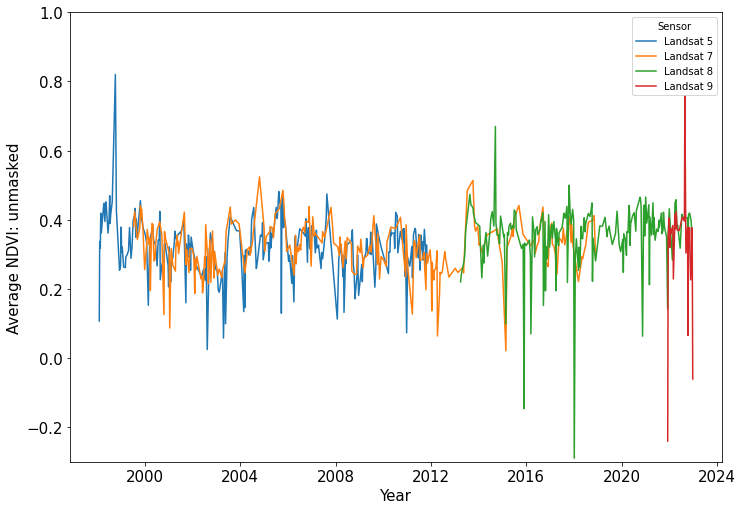

In [58]:
#Plotting unflats-masked ndvi
import seaborn as sns
import matplotlib.pyplot as plt

df = flats_series.copy()
df = df[df['ndvi_y']<1] #Quick fix

df.reset_index(inplace=True, drop=True)
df = df[df['ndvi_x'].notna()]

df = df[df['count_x']>40] #100 for expanded flux area

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "date", y = "ndvi_x", hue = "Sensor_x", data = df)
g.set_xlabel("Year",fontsize=15)
g.set_ylabel("Average NDVI: unmasked",fontsize=15)
g.tick_params(labelsize=15)
ax.set(ylim=(-0.3, 1))
plt.legend(title='Sensor')

# plt.savefig('flux_unmasked_timeseries.png', bbox_inches='tight', dpi = 300)

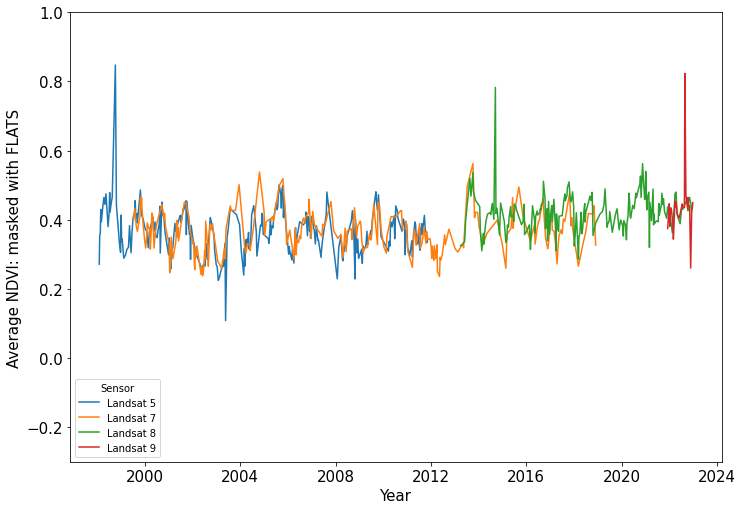

In [57]:
#Plotting masked flats
import seaborn as sns
import matplotlib.pyplot as plt

df = flats_series.copy()
# df = df[df['ndvi_y']<1] #Quick fix
df = df[df['count_x']>40] #100 for expanded flux area

df.reset_index(inplace=True, drop=True)
df = df[df['ndvi_x'].notna()]

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "date", y = "ndvi_y", hue = "Sensor_x", data = df)
g.set(xlabel ="Year", ylabel = "Average NDVI: masked with FLATS")
g.set_xlabel("Year",fontsize=15)
g.set_ylabel("Average NDVI: masked with FLATS",fontsize=15)
g.tick_params(labelsize=15)
ax.set(ylim=(-0.3, 1))
plt.legend(title='Sensor')

# plt.savefig('flux_masked_timeseries.png', bbox_inches='tight', dpi = 300)

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'ndvi, no flooded pixels')]

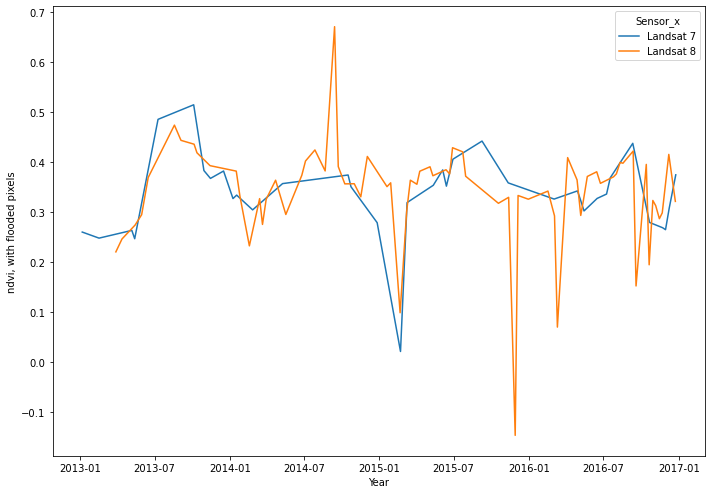

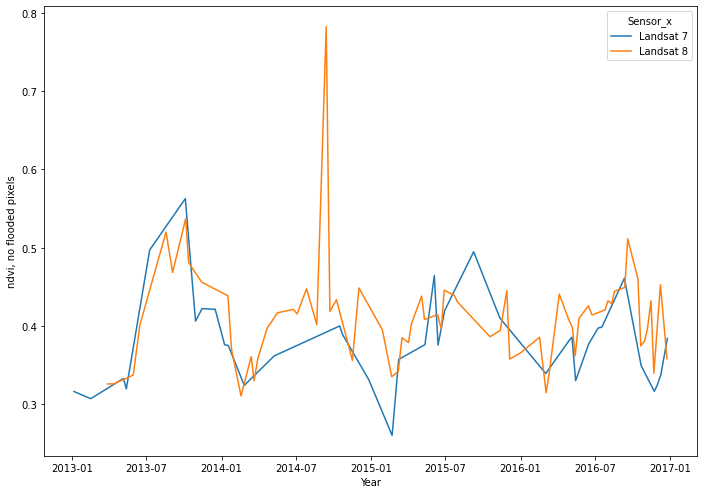

In [60]:
#Zooming in
df = flats_series.copy()
df.reset_index(inplace=True, drop=True)
df = df[df['ndvi_y'].notna()]
# df = df[df['ndvi_y']<1] #Quick fix
df = df[df['count_x']>40] #100 for expanded flux area

start_date = '2013-1-1'
end_date = '2016-12-31'

df = df[(df['date'] > start_date) & (df['date'] <= end_date)]

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g = sns.lineplot(ax = ax, x = "date", y = "ndvi_x", hue = "Sensor_x", data = df)
g.set(xlabel ="Year", ylabel = "ndvi, with flooded pixels")

dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=dims)
g1 = sns.lineplot(ax = ax, x = "date", y = "ndvi_y", hue = "Sensor_x", data = df)
g1.set(xlabel ="Year", ylabel = "ndvi, no flooded pixels")

In [ ]:
#Feesh